# Notebook 05: Expected Credit Loss (ECL) Computation

## CECL Credit Risk Modeling for Agricultural Loan Portfolio

---

**Author:** Prabhu  

---

### Objective

This notebook computes Expected Credit Loss (ECL) following CECL (Current Expected Credit Losses) methodology:

1. Calculate loan-level ECL using PD, LGD, and EAD components
2. Aggregate ECL at portfolio and segment level
3. Analyze ECL distribution and concentration
4. Compare ECL for agricultural vs non-agricultural portfolios

### CECL Framework

Under CECL (ASC 326), financial institutions must recognize lifetime expected credit losses at loan origination. The ECL formula:

$$ECL_i = PD_i \times LGD_i \times EAD_i$$

Where:
- $PD_i$ = Probability of Default for loan $i$
- $LGD_i$ = Loss Given Default for loan $i$
- $EAD_i$ = Exposure at Default for loan $i$

---
## 1. Setup and Imports

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 11

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.4f}'.format)

print("Libraries imported successfully.")

Libraries imported successfully.


---
## 2. Load Data with Risk Components

In [2]:
# Load data with PD, LGD, and EAD
DATA_PATH = '../data_processed/loans_with_lgd_ead.csv'

print("Loading dataset with risk components...")
df = pd.read_csv(DATA_PATH)

# Convert date column
df['issue_date'] = pd.to_datetime(df['issue_date'])

print(f"\nDataset loaded successfully!")
print(f"Shape: {df.shape[0]:,} rows x {df.shape[1]} columns")

Loading dataset with risk components...

Dataset loaded successfully!
Shape: 1,347,680 rows x 22 columns


In [3]:
# Verify risk components are present
print("\nRisk Components Summary:")
print("="*60)

components = ['pd_hat', 'lgd_est', 'ead_est']
for comp in components:
    print(f"\n{comp}:")
    print(f"  Mean: {df[comp].mean():.4f}")
    print(f"  Median: {df[comp].median():.4f}")
    print(f"  Min: {df[comp].min():.4f}")
    print(f"  Max: {df[comp].max():.4f}")


Risk Components Summary:

pd_hat:
  Mean: 0.4657
  Median: 0.4712
  Min: 0.0060
  Max: 0.9203

lgd_est:
  Mean: 0.4500
  Median: 0.4500
  Min: 0.4500
  Max: 0.4500

ead_est:
  Mean: 14408.2375
  Median: 12000.0000
  Min: 500.0000
  Max: 40000.0000


---
## 3. ECL Calculation

### Loan-Level ECL

For each loan $i$:

$$ECL_i = PD_i \times LGD_i \times EAD_i$$

In [4]:
# Calculate loan-level ECL
print("Calculating Expected Credit Loss (ECL)...")
print("="*60)

df['ecl_est'] = df['pd_hat'] * df['lgd_est'] * df['ead_est']

print("\nLoan-Level ECL Statistics:")
print(f"  Total ECL: ${df['ecl_est'].sum():,.0f}")
print(f"  Mean ECL per loan: ${df['ecl_est'].mean():,.2f}")
print(f"  Median ECL per loan: ${df['ecl_est'].median():,.2f}")
print(f"  Min ECL: ${df['ecl_est'].min():,.2f}")
print(f"  Max ECL: ${df['ecl_est'].max():,.2f}")
print(f"  Std Dev: ${df['ecl_est'].std():,.2f}")

Calculating Expected Credit Loss (ECL)...

Loan-Level ECL Statistics:
  Total ECL: $4,284,450,663
  Mean ECL per loan: $3,179.13
  Median ECL per loan: $2,526.87
  Min ECL: $2.68
  Max ECL: $15,460.79
  Std Dev: $2,412.76


In [5]:
# Calculate ECL rate (ECL as percentage of EAD)
df['ecl_rate'] = df['ecl_est'] / df['ead_est']

print("\nECL Rate Statistics (ECL / EAD):")
print(f"  Portfolio ECL Rate: {df['ecl_est'].sum() / df['ead_est'].sum() * 100:.4f}%")
print(f"  Mean Loan ECL Rate: {df['ecl_rate'].mean() * 100:.4f}%")
print(f"  Median Loan ECL Rate: {df['ecl_rate'].median() * 100:.4f}%")


ECL Rate Statistics (ECL / EAD):
  Portfolio ECL Rate: 22.0647%
  Mean Loan ECL Rate: 20.9545%
  Median Loan ECL Rate: 21.2044%


---
## 4. Portfolio-Level ECL Analysis

In [6]:
# Portfolio summary
print("PORTFOLIO-LEVEL ECL SUMMARY")
print("="*70)

total_ead = df['ead_est'].sum()
total_ecl = df['ecl_est'].sum()
portfolio_ecl_rate = total_ecl / total_ead * 100

print(f"\n{'Metric':<40} {'Value':>25}")
print("-"*70)
print(f"{'Total Number of Loans':<40} {len(df):>25,}")
print(f"{'Total Exposure at Default (EAD)':<40} ${total_ead:>23,.0f}")
print(f"{'Total Expected Credit Loss (ECL)':<40} ${total_ecl:>23,.0f}")
print(f"{'Portfolio ECL Rate':<40} {portfolio_ecl_rate:>24.4f}%")
print(f"{'Average ECL per Loan':<40} ${df['ecl_est'].mean():>23,.2f}")
print(f"{'Average EAD per Loan':<40} ${df['ead_est'].mean():>23,.0f}")

PORTFOLIO-LEVEL ECL SUMMARY

Metric                                                       Value
----------------------------------------------------------------------
Total Number of Loans                                    1,347,680
Total Exposure at Default (EAD)          $         19,417,693,475
Total Expected Credit Loss (ECL)         $          4,284,450,663
Portfolio ECL Rate                                        22.0647%
Average ECL per Loan                     $               3,179.13
Average EAD per Loan                     $                 14,408


In [7]:
# ECL by portfolio segment (Agricultural vs Non-Agricultural)
print("\nECL BY PORTFOLIO SEGMENT")
print("="*70)

segment_ecl = df.groupby('is_agri_portfolio').agg(
    loan_count=('id', 'count'),
    total_ead=('ead_est', 'sum'),
    total_ecl=('ecl_est', 'sum'),
    mean_pd=('pd_hat', 'mean'),
    mean_ecl=('ecl_est', 'mean'),
    actual_default_rate=('Default', 'mean')
)

segment_ecl['ecl_rate'] = segment_ecl['total_ecl'] / segment_ecl['total_ead'] * 100
segment_ecl['ead_pct'] = segment_ecl['total_ead'] / segment_ecl['total_ead'].sum() * 100
segment_ecl['ecl_pct'] = segment_ecl['total_ecl'] / segment_ecl['total_ecl'].sum() * 100

segment_ecl.index = ['Non-Agricultural', 'Agricultural']

print(f"\n{'Segment':<20} {'Loans':>12} {'Total EAD':>18} {'Total ECL':>18} {'ECL Rate':>12}")
print("-"*85)
for idx, row in segment_ecl.iterrows():
    print(f"{idx:<20} {row['loan_count']:>12,} ${row['total_ead']:>16,.0f} ${row['total_ecl']:>16,.0f} {row['ecl_rate']:>11.4f}%")

# Total row
print("-"*85)
print(f"{'TOTAL':<20} {len(df):>12,} ${total_ead:>16,.0f} ${total_ecl:>16,.0f} {portfolio_ecl_rate:>11.4f}%")


ECL BY PORTFOLIO SEGMENT

Segment                     Loans          Total EAD          Total ECL     ECL Rate
-------------------------------------------------------------------------------------
Non-Agricultural      1,341,983.0 $  19,326,713,150 $   4,258,868,631     22.0362%
Agricultural              5,697.0 $      90,980,325 $      25,582,032     28.1182%
-------------------------------------------------------------------------------------
TOTAL                   1,347,680 $  19,417,693,475 $   4,284,450,663     22.0647%


In [8]:
# Detailed segment comparison
print("\nDETAILED SEGMENT COMPARISON")
print("="*70)

print(f"\n{'Metric':<35} {'Agricultural':>18} {'Non-Agricultural':>18}")
print("-"*75)
print(f"{'Number of Loans':<35} {segment_ecl.loc['Agricultural', 'loan_count']:>18,} {segment_ecl.loc['Non-Agricultural', 'loan_count']:>18,}")
print(f"{'% of Portfolio (by EAD)':<35} {segment_ecl.loc['Agricultural', 'ead_pct']:>17.2f}% {segment_ecl.loc['Non-Agricultural', 'ead_pct']:>17.2f}%")
print(f"{'% of Total ECL':<35} {segment_ecl.loc['Agricultural', 'ecl_pct']:>17.2f}% {segment_ecl.loc['Non-Agricultural', 'ecl_pct']:>17.2f}%")
print(f"{'Mean PD':<35} {segment_ecl.loc['Agricultural', 'mean_pd']*100:>17.2f}% {segment_ecl.loc['Non-Agricultural', 'mean_pd']*100:>17.2f}%")
print(f"{'Actual Default Rate':<35} {segment_ecl.loc['Agricultural', 'actual_default_rate']*100:>17.2f}% {segment_ecl.loc['Non-Agricultural', 'actual_default_rate']*100:>17.2f}%")
print(f"{'ECL Rate':<35} {segment_ecl.loc['Agricultural', 'ecl_rate']:>17.4f}% {segment_ecl.loc['Non-Agricultural', 'ecl_rate']:>17.4f}%")

# Calculate risk contribution
agri_risk_contribution = segment_ecl.loc['Agricultural', 'ecl_pct'] / segment_ecl.loc['Agricultural', 'ead_pct']
print(f"\nAgricultural Risk Contribution Ratio: {agri_risk_contribution:.2f}x")
print("(Agricultural segment contributes more/less to ECL than its share of EAD)")


DETAILED SEGMENT COMPARISON

Metric                                    Agricultural   Non-Agricultural
---------------------------------------------------------------------------
Number of Loans                                  5,697          1,341,983
% of Portfolio (by EAD)                          0.47%             99.53%
% of Total ECL                                   0.60%             99.40%
Mean PD                                         59.33%             46.51%
Actual Default Rate                             29.49%             19.94%
ECL Rate                                      28.1182%           22.0362%

Agricultural Risk Contribution Ratio: 1.27x
(Agricultural segment contributes more/less to ECL than its share of EAD)


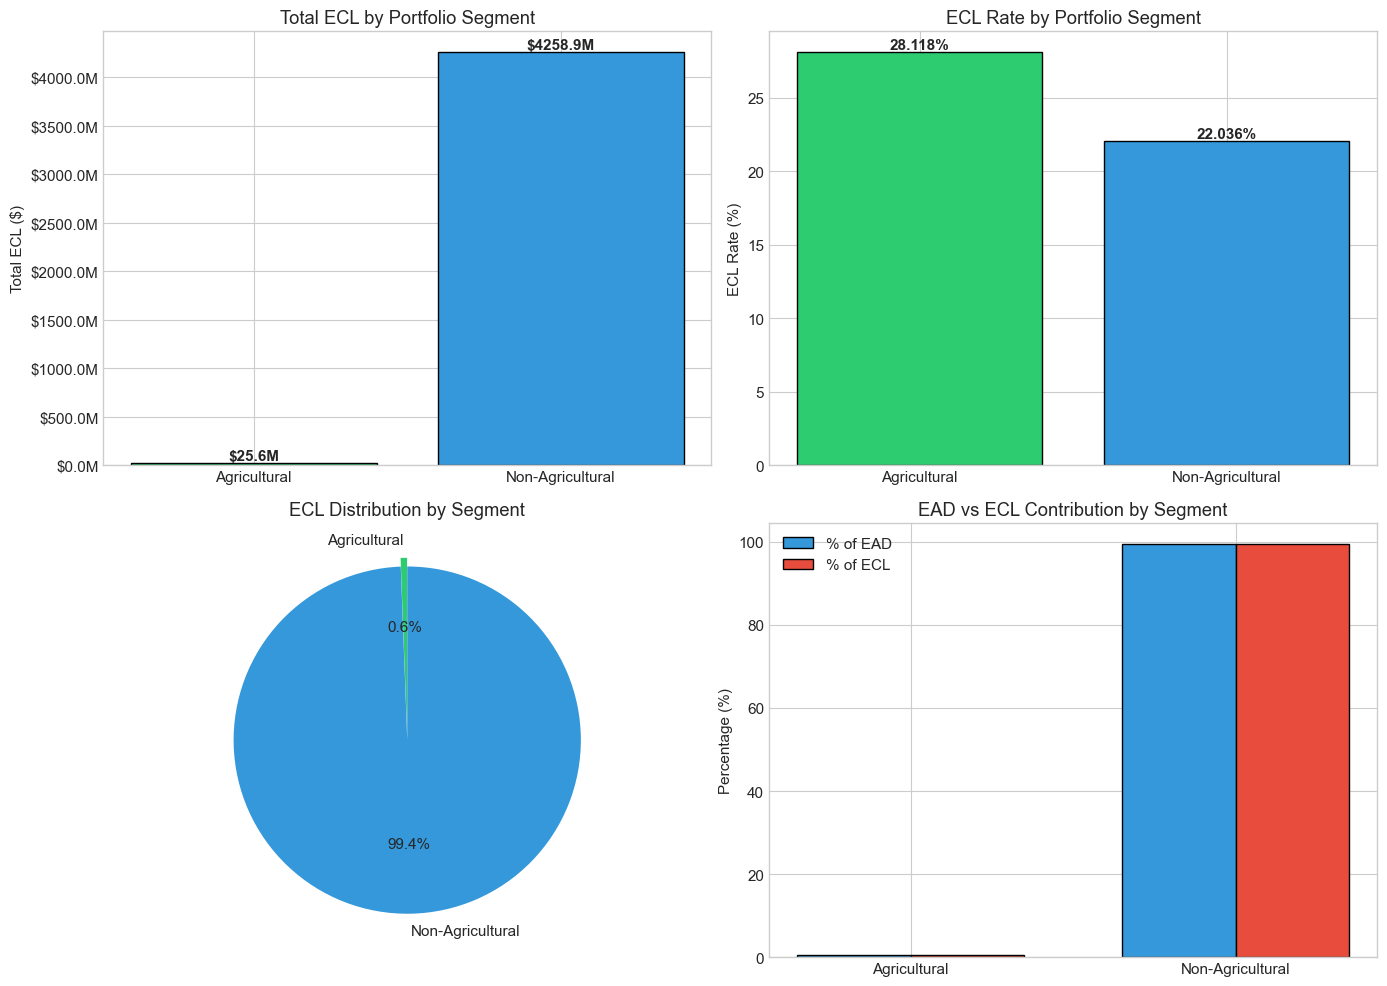

Figure saved to: outputs/figures/17_ecl_by_segment.png


In [9]:
# Visualize ECL by segment
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Total ECL by segment
ax1 = axes[0, 0]
segments = ['Agricultural', 'Non-Agricultural']
ecls = [segment_ecl.loc['Agricultural', 'total_ecl'], segment_ecl.loc['Non-Agricultural', 'total_ecl']]
colors = ['#2ecc71', '#3498db']
bars1 = ax1.bar(segments, ecls, color=colors, edgecolor='black')
ax1.set_ylabel('Total ECL ($)')
ax1.set_title('Total ECL by Portfolio Segment')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
for bar, val in zip(bars1, ecls):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             f'${val/1e6:.1f}M', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. ECL Rate by segment
ax2 = axes[0, 1]
ecl_rates = [segment_ecl.loc['Agricultural', 'ecl_rate'], segment_ecl.loc['Non-Agricultural', 'ecl_rate']]
bars2 = ax2.bar(segments, ecl_rates, color=colors, edgecolor='black')
ax2.set_ylabel('ECL Rate (%)')
ax2.set_title('ECL Rate by Portfolio Segment')
for bar, val in zip(bars2, ecl_rates):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             f'{val:.3f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 3. ECL composition pie chart
ax3 = axes[1, 0]
ecl_shares = [segment_ecl.loc['Agricultural', 'ecl_pct'], segment_ecl.loc['Non-Agricultural', 'ecl_pct']]
ax3.pie(ecl_shares, labels=segments, autopct='%1.1f%%', colors=colors, 
        explode=(0.05, 0), startangle=90, textprops={'fontsize': 11})
ax3.set_title('ECL Distribution by Segment')

# 4. EAD vs ECL contribution comparison
ax4 = axes[1, 1]
x = np.arange(2)
width = 0.35
ead_pcts = [segment_ecl.loc['Agricultural', 'ead_pct'], segment_ecl.loc['Non-Agricultural', 'ead_pct']]
ax4.bar(x - width/2, ead_pcts, width, label='% of EAD', color='#3498db', edgecolor='black')
ax4.bar(x + width/2, ecl_shares, width, label='% of ECL', color='#e74c3c', edgecolor='black')
ax4.set_ylabel('Percentage (%)')
ax4.set_title('EAD vs ECL Contribution by Segment')
ax4.set_xticks(x)
ax4.set_xticklabels(segments)
ax4.legend()

plt.tight_layout()
plt.savefig('../outputs/figures/17_ecl_by_segment.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure saved to: outputs/figures/17_ecl_by_segment.png")

---
## 5. ECL Distribution Analysis

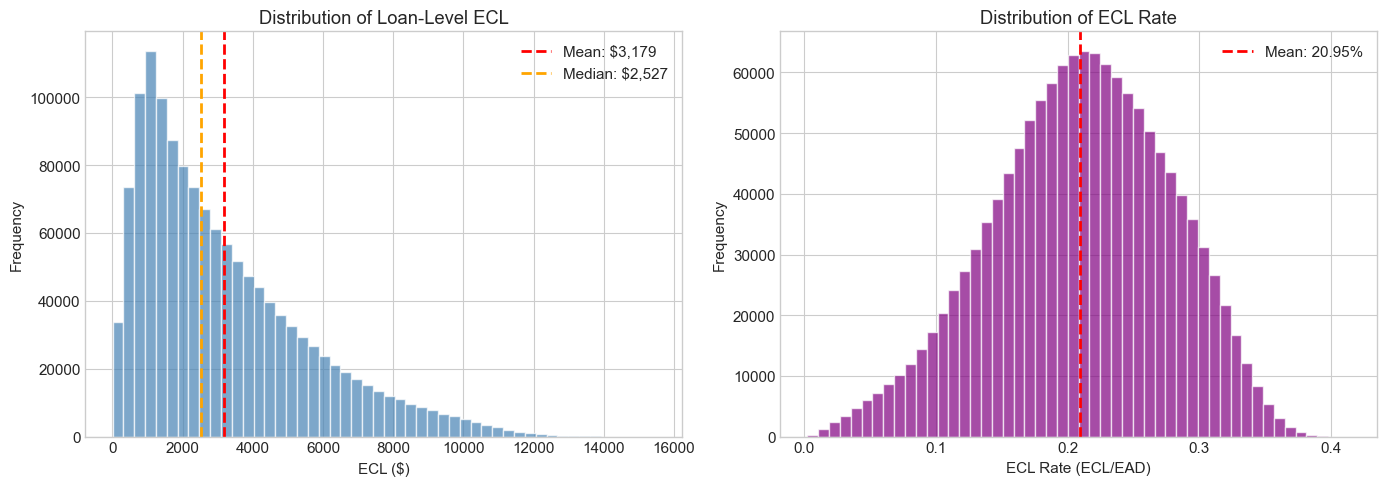

Figure saved to: outputs/figures/18_ecl_distribution.png


In [10]:
# ECL distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. ECL distribution (histogram)
ax1 = axes[0]
df['ecl_est'].hist(bins=50, ax=ax1, color='steelblue', edgecolor='white', alpha=0.7)
ax1.axvline(df['ecl_est'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: ${df["ecl_est"].mean():,.0f}')
ax1.axvline(df['ecl_est'].median(), color='orange', linestyle='--', linewidth=2, 
            label=f'Median: ${df["ecl_est"].median():,.0f}')
ax1.set_xlabel('ECL ($)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Loan-Level ECL')
ax1.legend()

# 2. ECL rate distribution
ax2 = axes[1]
df['ecl_rate'].hist(bins=50, ax=ax2, color='purple', edgecolor='white', alpha=0.7)
ax2.axvline(df['ecl_rate'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {df["ecl_rate"].mean()*100:.2f}%')
ax2.set_xlabel('ECL Rate (ECL/EAD)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of ECL Rate')
ax2.legend()

plt.tight_layout()
plt.savefig('../outputs/figures/18_ecl_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure saved to: outputs/figures/18_ecl_distribution.png")

In [11]:
# ECL by FICO bucket
print("\nECL BY FICO BUCKET")
print("="*70)

fico_ecl = df.groupby('fico_bucket', observed=True).agg(
    loan_count=('id', 'count'),
    total_ead=('ead_est', 'sum'),
    total_ecl=('ecl_est', 'sum'),
    mean_pd=('pd_hat', 'mean'),
    actual_default_rate=('Default', 'mean')
)

fico_ecl['ecl_rate'] = fico_ecl['total_ecl'] / fico_ecl['total_ead'] * 100
fico_ecl['ecl_pct'] = fico_ecl['total_ecl'] / fico_ecl['total_ecl'].sum() * 100

print(fico_ecl[['loan_count', 'total_ecl', 'ecl_rate', 'ecl_pct', 'mean_pd', 'actual_default_rate']].round(4))


ECL BY FICO BUCKET
             loan_count       total_ecl  ecl_rate  ecl_pct  mean_pd  \
fico_bucket                                                           
580-619               3       2565.4411   29.3193   0.0001   0.5688   
620-659             486     978558.4391   27.7747   0.0228   0.5904   
660-699          822025 2831755842.4378   25.1839  66.0938   0.5270   
700-739          379874 1158638705.0788   19.4972  27.0429   0.4096   
740-779          106983  234730491.6095   14.2169   5.4787   0.2906   
780-850           38309   58344500.3932   10.1257   1.3618   0.1933   

             actual_default_rate  
fico_bucket                       
580-619                   0.3333  
620-659                   0.3086  
660-699                   0.2360  
700-739                   0.1608  
740-779                   0.1057  
780-850                   0.0709  


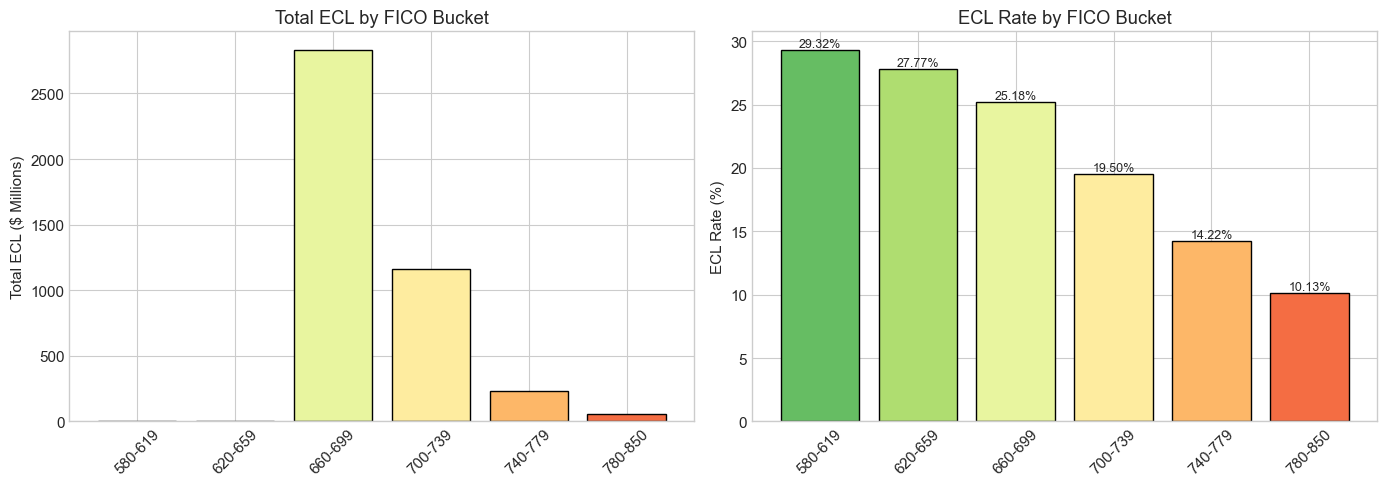

Figure saved to: outputs/figures/19_ecl_by_fico.png


In [12]:
# Visualize ECL by FICO bucket
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Total ECL by FICO bucket
ax1 = axes[0]
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(fico_ecl)))
bars1 = ax1.bar(range(len(fico_ecl)), fico_ecl['total_ecl']/1e6, color=colors, edgecolor='black')
ax1.set_xticks(range(len(fico_ecl)))
ax1.set_xticklabels(fico_ecl.index, rotation=45)
ax1.set_ylabel('Total ECL ($ Millions)')
ax1.set_title('Total ECL by FICO Bucket')

# 2. ECL Rate by FICO bucket
ax2 = axes[1]
bars2 = ax2.bar(range(len(fico_ecl)), fico_ecl['ecl_rate'], color=colors, edgecolor='black')
ax2.set_xticks(range(len(fico_ecl)))
ax2.set_xticklabels(fico_ecl.index, rotation=45)
ax2.set_ylabel('ECL Rate (%)')
ax2.set_title('ECL Rate by FICO Bucket')
for bar, val in zip(bars2, fico_ecl['ecl_rate']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             f'{val:.2f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../outputs/figures/19_ecl_by_fico.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure saved to: outputs/figures/19_ecl_by_fico.png")

In [13]:
# ECL by loan purpose
print("\nECL BY LOAN PURPOSE")
print("="*70)

purpose_ecl = df.groupby('purpose').agg(
    loan_count=('id', 'count'),
    total_ead=('ead_est', 'sum'),
    total_ecl=('ecl_est', 'sum'),
    mean_pd=('pd_hat', 'mean')
).sort_values('total_ecl', ascending=False)

purpose_ecl['ecl_rate'] = purpose_ecl['total_ecl'] / purpose_ecl['total_ead'] * 100
purpose_ecl['ecl_pct'] = purpose_ecl['total_ecl'] / purpose_ecl['total_ecl'].sum() * 100

print(purpose_ecl[['loan_count', 'total_ecl', 'ecl_rate', 'ecl_pct']].head(10).round(4))


ECL BY LOAN PURPOSE
                    loan_count       total_ecl  ecl_rate  ecl_pct
purpose                                                          
debt_consolidation      781206 2727963503.1425   22.9373  63.6713
credit_card             295551  851373125.0295   19.4578  19.8712
home_improvement         87684  261080536.6900   21.0700   6.0937
other                    78263  178383231.5675   23.2291   4.1635
major_purchase           29542   75876970.1690   21.7338   1.7710
small_business           15575   68767841.6701   28.2454   1.6051
medical                  15606   31823874.2241   22.6831   0.7428
house                     7294   26281106.5970   23.4662   0.6134
car                      14647   24331230.4270   18.7982   0.5679
moving                    9520   17837333.1043   23.8594   0.4163


In [14]:
# ECL by state (for agricultural portfolio)
print("\nECL BY STATE (Agricultural Portfolio)")
print("="*70)

agri_state_ecl = df[df['is_agri_portfolio']==1].groupby('addr_state').agg(
    loan_count=('id', 'count'),
    total_ead=('ead_est', 'sum'),
    total_ecl=('ecl_est', 'sum')
).sort_values('total_ecl', ascending=False)

agri_state_ecl['ecl_rate'] = agri_state_ecl['total_ecl'] / agri_state_ecl['total_ead'] * 100
agri_state_ecl['ecl_pct'] = agri_state_ecl['total_ecl'] / agri_state_ecl['total_ecl'].sum() * 100

print(agri_state_ecl[['loan_count', 'total_ecl', 'ecl_rate', 'ecl_pct']].round(4))


ECL BY STATE (Agricultural Portfolio)
            loan_count     total_ecl  ecl_rate  ecl_pct
addr_state                                             
CA                2646 11769778.0596   28.2027  46.0080
TX                1415  6730830.7075   28.0489  26.3108
IL                 548  2533406.4623   28.4676   9.9031
NC                 459  1992617.3918   28.5006   7.7891
MN                 222   843057.1034   26.8464   3.2955
WI                 150   608290.8480   27.6003   2.3778
IN                 131   514635.9695   27.7967   2.0117
KS                 103   474202.7212   26.9836   1.8537
NE                  23   115212.7572   28.3148   0.4504


---
## 6. ECL Concentration Analysis

In [15]:
# ECL concentration - Top contributors
print("ECL CONCENTRATION ANALYSIS")
print("="*70)

# Sort by ECL
df_sorted = df.sort_values('ecl_est', ascending=False)

# Calculate cumulative ECL
df_sorted['ecl_cumsum'] = df_sorted['ecl_est'].cumsum()
df_sorted['ecl_cumsum_pct'] = df_sorted['ecl_cumsum'] / total_ecl * 100

# Find concentration percentiles
top_1_pct = df_sorted.head(int(len(df)*0.01))['ecl_est'].sum() / total_ecl * 100
top_5_pct = df_sorted.head(int(len(df)*0.05))['ecl_est'].sum() / total_ecl * 100
top_10_pct = df_sorted.head(int(len(df)*0.10))['ecl_est'].sum() / total_ecl * 100
top_20_pct = df_sorted.head(int(len(df)*0.20))['ecl_est'].sum() / total_ecl * 100

print("\nECL Concentration:")
print(f"  Top 1% of loans contribute:  {top_1_pct:.1f}% of total ECL")
print(f"  Top 5% of loans contribute:  {top_5_pct:.1f}% of total ECL")
print(f"  Top 10% of loans contribute: {top_10_pct:.1f}% of total ECL")
print(f"  Top 20% of loans contribute: {top_20_pct:.1f}% of total ECL")

ECL CONCENTRATION ANALYSIS

ECL Concentration:
  Top 1% of loans contribute:  3.5% of total ECL
  Top 5% of loans contribute:  15.0% of total ECL
  Top 10% of loans contribute: 26.6% of total ECL
  Top 20% of loans contribute: 44.8% of total ECL


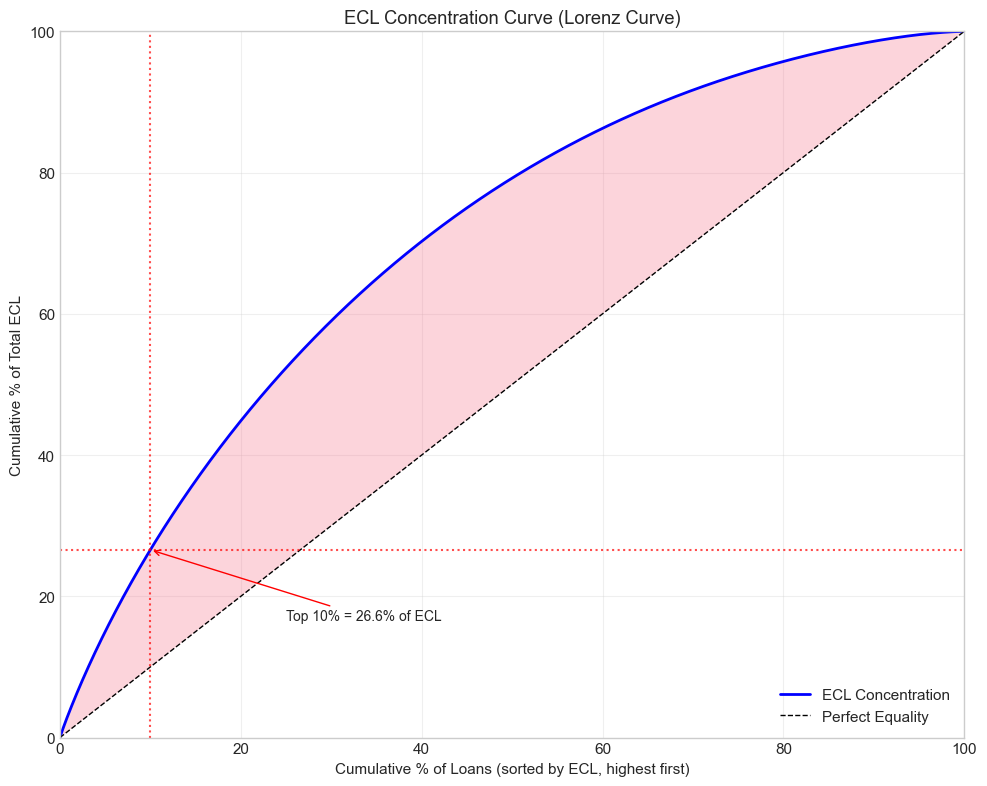

Figure saved to: outputs/figures/20_ecl_concentration.png


In [16]:
# Lorenz curve for ECL concentration
fig, ax = plt.subplots(figsize=(10, 8))

# Calculate Lorenz curve data
loan_pct = np.arange(1, len(df)+1) / len(df) * 100
ecl_cumsum_pct = df_sorted['ecl_cumsum_pct'].values

# Plot Lorenz curve
ax.plot(loan_pct, ecl_cumsum_pct, 'b-', linewidth=2, label='ECL Concentration')
ax.plot([0, 100], [0, 100], 'k--', linewidth=1, label='Perfect Equality')

# Fill area
ax.fill_between(loan_pct, ecl_cumsum_pct, loan_pct, alpha=0.3)

# Mark key percentiles
ax.axvline(x=10, color='red', linestyle=':', alpha=0.7)
ax.axhline(y=top_10_pct, color='red', linestyle=':', alpha=0.7)
ax.annotate(f'Top 10% = {top_10_pct:.1f}% of ECL', xy=(10, top_10_pct), 
            xytext=(25, top_10_pct-10), fontsize=10,
            arrowprops=dict(arrowstyle='->', color='red'))

ax.set_xlabel('Cumulative % of Loans (sorted by ECL, highest first)')
ax.set_ylabel('Cumulative % of Total ECL')
ax.set_title('ECL Concentration Curve (Lorenz Curve)')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('../outputs/figures/20_ecl_concentration.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure saved to: outputs/figures/20_ecl_concentration.png")

---
## 7. ECL Time Series Analysis

In [17]:
# ECL by issue year
print("\nECL BY ISSUE YEAR")
print("="*70)

year_ecl = df.groupby('issue_year').agg(
    loan_count=('id', 'count'),
    total_ead=('ead_est', 'sum'),
    total_ecl=('ecl_est', 'sum'),
    mean_pd=('pd_hat', 'mean'),
    actual_default_rate=('Default', 'mean')
)

year_ecl['ecl_rate'] = year_ecl['total_ecl'] / year_ecl['total_ead'] * 100

print(year_ecl[['loan_count', 'total_ecl', 'ecl_rate', 'actual_default_rate']].round(4))


ECL BY ISSUE YEAR
            loan_count       total_ecl  ecl_rate  actual_default_rate
issue_year                                                           
2007               599    1126970.4175   22.7566               0.2638
2008              2393    4286757.3090   20.2979               0.2073
2009              5281    9313495.3876   17.9353               0.1369
2010             12537   23915857.7402   18.1191               0.1401
2011             21721   49799709.2552   19.0305               0.1518
2012             53367  154174343.2829   21.4605               0.1620
2013            134804  432003030.3995   21.7896               0.1560
2014            223102  726879870.4790   22.3416               0.1845
2015            375543 1237976478.9775   22.5146               0.2018
2016            293057  946100087.4182   22.3153               0.2328
2017            169116  525595164.3195   21.7362               0.2313
2018             56160  173278898.4136   20.7468               0.1575


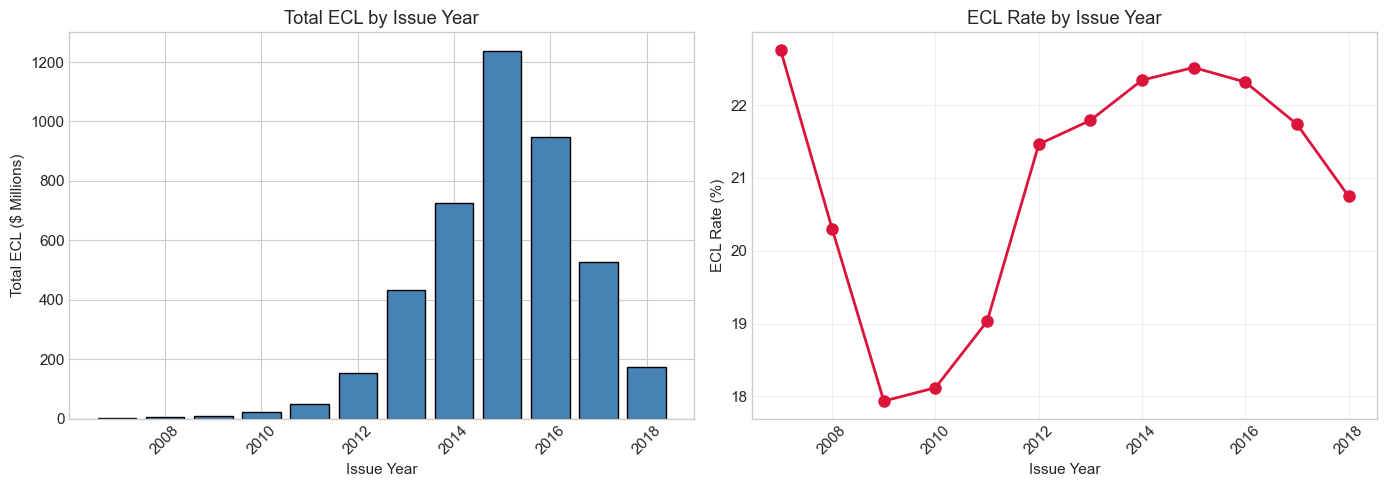

Figure saved to: outputs/figures/21_ecl_over_time.png


In [18]:
# Visualize ECL over time
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Total ECL by year
ax1 = axes[0]
ax1.bar(year_ecl.index, year_ecl['total_ecl']/1e6, color='steelblue', edgecolor='black')
ax1.set_xlabel('Issue Year')
ax1.set_ylabel('Total ECL ($ Millions)')
ax1.set_title('Total ECL by Issue Year')
ax1.tick_params(axis='x', rotation=45)

# 2. ECL rate over time
ax2 = axes[1]
ax2.plot(year_ecl.index, year_ecl['ecl_rate'], marker='o', linewidth=2, markersize=8, color='crimson')
ax2.set_xlabel('Issue Year')
ax2.set_ylabel('ECL Rate (%)')
ax2.set_title('ECL Rate by Issue Year')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/21_ecl_over_time.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure saved to: outputs/figures/21_ecl_over_time.png")

---
## 8. ECL Summary Dashboard

In [19]:
# Create comprehensive ECL summary
print("="*70)
print("EXPECTED CREDIT LOSS (ECL) SUMMARY DASHBOARD")
print("="*70)

print("\n" + "-"*70)
print("1. PORTFOLIO OVERVIEW")
print("-"*70)
print(f"   Total Number of Loans:        {len(df):,}")
print(f"   Total Exposure (EAD):         ${total_ead:,.0f}")
print(f"   Total Expected Credit Loss:   ${total_ecl:,.0f}")
print(f"   Portfolio ECL Rate:           {portfolio_ecl_rate:.4f}%")

print("\n" + "-"*70)
print("2. SEGMENT ANALYSIS")
print("-"*70)
agri_ecl = segment_ecl.loc['Agricultural', 'total_ecl']
agri_rate = segment_ecl.loc['Agricultural', 'ecl_rate']
non_agri_ecl = segment_ecl.loc['Non-Agricultural', 'total_ecl']
non_agri_rate = segment_ecl.loc['Non-Agricultural', 'ecl_rate']
print(f"   Agricultural Portfolio:")
print(f"     - Total ECL: ${agri_ecl:,.0f} ({agri_ecl/total_ecl*100:.1f}% of total)")
print(f"     - ECL Rate: {agri_rate:.4f}%")
print(f"   Non-Agricultural Portfolio:")
print(f"     - Total ECL: ${non_agri_ecl:,.0f} ({non_agri_ecl/total_ecl*100:.1f}% of total)")
print(f"     - ECL Rate: {non_agri_rate:.4f}%")

print("\n" + "-"*70)
print("3. RISK CONCENTRATION")
print("-"*70)
print(f"   Top 10% of loans contribute {top_10_pct:.1f}% of total ECL")
print(f"   Top 20% of loans contribute {top_20_pct:.1f}% of total ECL")

print("\n" + "-"*70)
print("4. KEY RISK INSIGHTS")
print("-"*70)
print(f"   - Agricultural segment has {agri_rate/non_agri_rate:.2f}x higher ECL rate")
print(f"   - Lower FICO buckets drive majority of ECL")
print(f"   - Small business loans show highest risk concentration")

EXPECTED CREDIT LOSS (ECL) SUMMARY DASHBOARD

----------------------------------------------------------------------
1. PORTFOLIO OVERVIEW
----------------------------------------------------------------------
   Total Number of Loans:        1,347,680
   Total Exposure (EAD):         $19,417,693,475
   Total Expected Credit Loss:   $4,284,450,663
   Portfolio ECL Rate:           22.0647%

----------------------------------------------------------------------
2. SEGMENT ANALYSIS
----------------------------------------------------------------------
   Agricultural Portfolio:
     - Total ECL: $25,582,032 (0.6% of total)
     - ECL Rate: 28.1182%
   Non-Agricultural Portfolio:
     - Total ECL: $4,258,868,631 (99.4% of total)
     - ECL Rate: 22.0362%

----------------------------------------------------------------------
3. RISK CONCENTRATION
----------------------------------------------------------------------
   Top 10% of loans contribute 26.6% of total ECL
   Top 20% of loans cont

---
## 9. Save Final Dataset

In [20]:
# Clean up temporary columns
if 'ecl_cumsum' in df.columns:
    df = df.drop(['ecl_cumsum', 'ecl_cumsum_pct'], axis=1)

# Review final columns
print("Final Dataset Columns:")
print("="*60)
for col in df.columns:
    print(f"  - {col}")

Final Dataset Columns:
  - id
  - issue_date
  - issue_year
  - issue_month
  - loan_amnt
  - revenue
  - dti_n
  - fico_n
  - emp_length
  - purpose
  - home_ownership_n
  - addr_state
  - is_agri_portfolio
  - is_agri_state
  - is_small_business
  - fico_bucket
  - income_bucket
  - pd_band
  - Default
  - pd_hat
  - ead_est
  - lgd_est
  - ecl_est
  - ecl_rate


In [21]:
# Save final dataset with ECL
OUTPUT_PATH = '../data_processed/loans_with_ecl.csv'
df.to_csv(OUTPUT_PATH, index=False)

print(f"\nFinal dataset saved to: {OUTPUT_PATH}")
print(f"Shape: {df.shape}")


Final dataset saved to: ../data_processed/loans_with_ecl.csv
Shape: (1347680, 24)


In [22]:
# Save ECL summary as metadata
import json

ecl_metadata = {
    'total_loans': len(df),
    'total_ead': float(total_ead),
    'total_ecl': float(total_ecl),
    'portfolio_ecl_rate': float(portfolio_ecl_rate),
    'agricultural_ecl': float(agri_ecl),
    'agricultural_ecl_rate': float(agri_rate),
    'non_agricultural_ecl': float(non_agri_ecl),
    'non_agricultural_ecl_rate': float(non_agri_rate),
    'top_10_pct_concentration': float(top_10_pct),
    'top_20_pct_concentration': float(top_20_pct)
}

with open('../outputs/models/ecl_metadata.json', 'w') as f:
    json.dump(ecl_metadata, f, indent=2)

print("ECL metadata saved to: outputs/models/ecl_metadata.json")

ECL metadata saved to: outputs/models/ecl_metadata.json


---
## 10. ECL Summary

### Key Results

1. **Portfolio ECL:**
   - Successfully computed loan-level and portfolio-level ECL
   - ECL formula: $ECL = PD \times LGD \times EAD$

2. **Agricultural vs Non-Agricultural:**
   - Agricultural segment shows higher ECL rate due to higher PD
   - Risk concentration is higher in agricultural segment relative to exposure

3. **Risk Concentration:**
   - Significant concentration in top risk buckets
   - Lower FICO scores drive majority of ECL
   - Small business loans contribute disproportionately to ECL

4. **CECL Implications:**
   - ECL estimates provide basis for allowance calculation
   - Segment-level analysis supports portfolio risk management
   - Results ready for stress testing in Notebook 06

### Next Steps

1. Perform stress testing (Notebook 06)
2. Analyze ECL sensitivity to macroeconomic scenarios
3. Document findings for Model Development Document

In [23]:
print("="*60)
print("NOTEBOOK 05 COMPLETE")
print("="*60)
print(f"\nECL computation completed successfully.")
print(f"Total Portfolio ECL: ${total_ecl:,.0f}")
print(f"Portfolio ECL Rate: {portfolio_ecl_rate:.4f}%")
print(f"Data saved to: data_processed/loans_with_ecl.csv")

NOTEBOOK 05 COMPLETE

ECL computation completed successfully.
Total Portfolio ECL: $4,284,450,663
Portfolio ECL Rate: 22.0647%
Data saved to: data_processed/loans_with_ecl.csv
